## Solve the **Schrödinger Equation** Using **Physics-Informed Neural Networks** (PINNs)

Initially, I will undertake the challenge of applying Physics-Informed Neural Networks (PINNs) to address the timeless **Schrödinger equation**, which is presented as:
\begin{equation*}
-\frac {\hbar^2}{2m} \frac {d^2 \Psi(x,t)}{dx^2} + (V(x)-E) \Psi(x,t) = 0
\end{equation*}

Utilizing the method of Separation of Variables, we derive the solution:
\begin{equation*}
\Psi_n(x,t) = \psi_n(x) \cdot \phi_n(t)
\end{equation*}

where $\phi(t) = e^{-i \frac{E_n \cdot t}{\hbar}}$ enables us to concentrate on the spatial component, \(\psi_n(x)\).

The scenario hinges on the potential function; for the sake of simplicity, we will examine the well-known scenario of an infinite square well with width $a$:
\begin{equation*}
V(x) =
\begin{cases}
0 & \text{for } 0 \leq x \leq a \\
\infty & \text{for } x < 0 \text{ or } x > a
\end{cases}
\end{equation*}

Given the boundary conditions:
$\psi(0) = 0 = \psi(a)$,

we arrive at the precise solution:
\begin{equation*}
\psi_n(x)= \sqrt{\frac{2}{a}} \sin\left(\frac{n \pi x}{a}\right)
\end{equation*}

where $n=1,2,3,\ldots$.

Acknowledging \(k= \frac{\sqrt{2mE}}{\hbar}\), and the boundary conditions lead to $k_n=\frac{n \pi}{a}$, which implies $E_n= \frac{n^2 \pi^2 \hbar^2}{2ma^2}$. This gives us a comprehensive understanding of the stationary states:
\begin{equation*}
\Psi_n(x,t)= \sqrt{\frac{2}{a}} \sin\left(\frac{n \pi x}{a}\right) e^{-i \frac{n^2 \pi^2 \hbar}{2ma^2}t}
\end{equation*}


In [51]:
import torch                     # PyTorch library for deep learning tasks
import torch.nn as nn            # PyTorch's neural network module
import numpy as np               # NumPy library for numerical operations
import matplotlib.pyplot as plt  # Matplotlib's pyplot: a plotting library
from tqdm import tqdm            # tqdm library for adding a progress meter to loops
import seaborn as sns            # Seaborn library for making statistical graphics

Function to compute

\begin{equation*}
\psi_n(x)= \sqrt{\frac{2}{a}} \sin\left(\frac{n \pi x}{a}\right)
\end{equation*}

In [3]:
def exact_solution(a, n, x):
    """
    Calculate the analytical solution of the time-independent Schrödinger equation for a particle in a 1D box.

    Parameters:
    - a: Length of the box.
    - n: Quantum number representing the energy state (e.g., n=1 for ground state).
    - x: Position within the box.

    Returns:
    - psi: Wave function of the particle at position x.
    """
    pi= np.pi
    psi = np.sqrt(2/a) * np.sin((n * pi * x) / a)  # Calculate wave function

    return psi

In [52]:
import torch.nn as nn

class FCN_TANH(nn.Module):
    """
    Defines a standard fully-connected network (FCN) with Tanh activation functions.
    This network consists of an input layer, several hidden layers, and an output layer.

    Parameters:
    - N_INPUT: Number of input features.
    - N_OUTPUT: Number of output features.
    - N_HIDDEN: Number of features in each hidden layer.
    - N_LAYERS: Total number of layers including the input layer but excluding the output layer.
    """

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        # Define the Tanh activation function to be used in the network
        activation = nn.Tanh
        # Initial fully connected layer from input to first hidden layer
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        # Hidden layers, excluding the first hidden layer
        # Creates N_LAYERS-1 of these since the first hidden layer is defined separately
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        # Output fully connected layer from last hidden layer to output
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        # Forward pass through the first hidden layer
        x = self.fcs(x)
        # Forward pass through the remaining hidden layers
        x = self.fch(x)
        # Final forward pass to get output
        x = self.fce(x)
        return x

#---------------------------------------------------------------------------------------------------------------------------
class FCN_GELU(nn.Module):
    """
    Similar to FCN_TANH but uses GELU (Gaussian Error Linear Unit) as the activation function.
    GELU is often used for models where slightly better performance is observed compared to ReLU in deep networks.
    """

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        # Define the GELU activation function to be used in the network
        activation = nn.GELU
        # The structure is identical to FCN_TANH, with the only difference being the activation function
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        # Forward pass is identical to that in FCN_TANH, with the GELU activation function
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

#---------------------------------------------------------------------------------------------------------------------------
class FCN_RELU(nn.Module):
    """
    Similar to FCN_TANH but uses ReLU (Rectified Linear Unit) as the activation function.
    ReLU is a widely used activation function that introduces non-linearity without affecting the scale of input.
    """

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        # Define the ReLU activation function to be used in the network
        activation = nn.ReLU
        # The structure is identical to FCN_TANH, with the only difference being the activation function
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        # Forward pass is identical to that in FCN_TANH, with the ReLU activation function
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


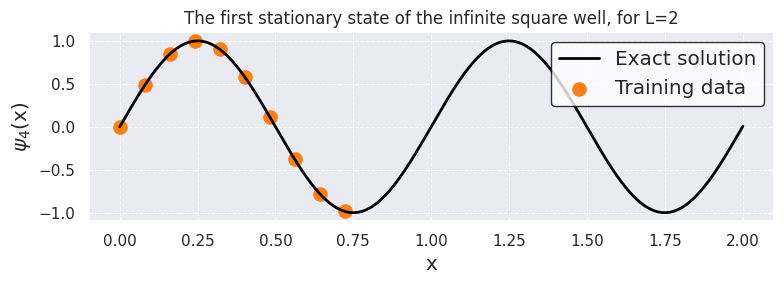

In [84]:
a, n = 2, 4

x = torch.linspace(0, a+0.001, 500).view(-1, 1)  # Generate a tensor of 500 linearly spaced points

y = exact_solution(a, n, x).view(-1, 1)          # Calculate the exact solution for the given quantum state over the entire domain

print(x.shape, y.shape)

# Select a subset of points for training data.
# Here, every 20th point from the first 200 points is chosen, focusing on the left-hand side (LHS) of the domain.
# This technique is often used to reduce the computational load or to focus on specific areas of interest.
x_data = x[0:200:20]
y_data = y[0:200:20]

print(x_data.shape, y_data.shape)

# Plot
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x, y, color='black', linewidth=2, label="Exact solution")
ax.scatter(x_data, y_data, color="tab:orange", s=90, edgecolor="tab:orange", label="Training data")
legend = ax.legend(frameon = True, loc='upper right', fontsize='large')
frame = legend.get_frame()
frame.set_color('white')
frame.set_edgecolor('black')
ax.set_xlabel("x", fontsize='large')
ax.set_ylabel("$\psi_4$(x)", fontsize='large')
ax.set_title("The first stationary state of the infinite square well, for L=2")
ax.grid(True, which='both', linestyle='--', linewidth=0.75)
plt.tight_layout()
plt.show()

In [93]:
def plot_result(x, y, x_data, y_data, yh):
    sns.set_theme(style="darkgrid")
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.plot(x, y, color='black', linewidth=2, label="Exact solution")
    ax.plot(x, yh, color="tab:red", linewidth=3, alpha=0.8,linestyle='--', label="Neural network prediction")
    ax.scatter(x_data, y_data, color="tab:orange", s=90, edgecolor="tab:orange", label="Training data")

    l = legend = ax.legend(frameon=True, loc='upper right')
    frame = legend.get_frame()
    frame.set_color('white')
    frame.set_edgecolor('black')
    plt.setp(legend.get_texts(), color="k")

    ax.set_xlabel("x", fontsize='large')
    ax.set_ylabel("$\psi$(x)", fontsize='large')
    ax.grid(True, which='both', linestyle='--', linewidth=0.75)
    plt.title(f"Training step: {i+1}")
    plt.tight_layout()
    plt.show()

In [116]:
def plot_losses(losses1, losses2=None, losses3=None, losses4=None, lossestot=None):
    """
    Plots the training loss over epochs for up to five different loss metrics.

    Parameters:
    - losses1: A list of loss values for the main model loss (e.g., Machine Learning Loss).
    - losses2: (Optional) A list of loss values for a different metric, such as differential equation loss.
    - losses3: (Optional) A list of loss values for the first boundary condition loss.
    - losses4: (Optional) A list of loss values for the second boundary condition loss.
    - lossestot: (Optional) A list of total loss values combining all losses.

    This function creates a line plot for each set of losses provided. If multiple loss lists are given,
    it plots each one on the same graph for easy comparison. Labels are added for clarity, and a legend is
    included to distinguish between the different loss types.
    """
    plt.figure()
    plt.title("Loss over epoch")

    plt.plot(losses1, label="ML Loss")

    # Check if additional losses were provided and plot them if they were.
    if None not in (losses2, losses3, losses4, lossestot):
        plt.plot(losses2, label="Dif Eq loss")
        plt.plot(losses3, label="Boundary 1 loss")
        plt.plot(losses4, label="Boundary 2 loss")
        plt.plot(lossestot, label="Total loss")

    plt.legend()
    plt.xlabel("Training step")
    plt.ylabel("Loss")
    plt.show()

In [125]:
import matplotlib.pyplot as plt

def plot_losses_2x2(losses1, losses2, losses3, losses4, lossestot):
    """
    Plot ML loss, Differential Equation loss, Boundary 1 and 2 loss, and Total loss in a 2x2 subplot grid with specific colors for each plot.
    """
    fig, axs = plt.subplots(2, 2, figsize=(6, 4)) # Create a 2x2 grid of subplots
    fig.suptitle("Loss Components Over Training Steps")

    # Plot ML Loss with a specific color
    axs[0, 0].plot(losses1, label="ML Loss", linewidth=2, color='blue') # Changed color to blue
    axs[0, 0].set_title("ML Loss")
    axs[0, 0].set_xlabel("Training Step")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].grid(True)

    # Plot Differential Equation Loss with a specific color
    axs[0, 1].plot(losses2, label="Differential Eq Loss", linestyle='--', linewidth=2, color='green') # Changed color to green
    axs[0, 1].set_title("Differential Eq Loss")
    axs[0, 1].set_xlabel("Training Step")
    axs[0, 1].set_ylabel("Loss")
    axs[0, 1].grid(True)

    # Plot Boundary 1 Loss with a specific color
    axs[1, 0].plot(losses3, label="Boundary 1 Loss", linestyle='-.', linewidth=2, color='red') # Changed color to red
    axs[1, 0].set_title("Boundary 1 Loss")
    axs[1, 0].set_xlabel("Training Step")
    axs[1, 0].set_ylabel("Loss")
    axs[1, 0].grid(True)

    # Plot Boundary 2 Loss with a specific color
    axs[1, 1].plot(losses4, label="Boundary 2 Loss", linestyle=':', linewidth=2, color='purple') # Changed color to purple
    axs[1, 1].set_title("Boundary 2 Loss")
    axs[1, 1].set_xlabel("Training Step")
    axs[1, 1].set_ylabel("Loss")
    axs[1, 1].grid(True)

    # Adjust layout and display plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the layout to make room for the main title
    plt.show()

    # Additional figure for Total Loss, if needed outside the 2x2 grid
    plt.figure(figsize=(6, 4))
    plt.plot(lossestot, label="Total Loss", alpha=0.7, linewidth=2, color='orange') # Changed color to orange for total loss
    plt.title("Total Loss")
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

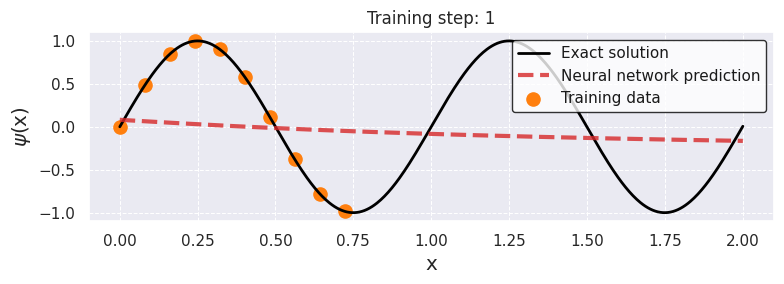

 48%|████▊     | 484/1000 [00:01<00:00, 559.58it/s]

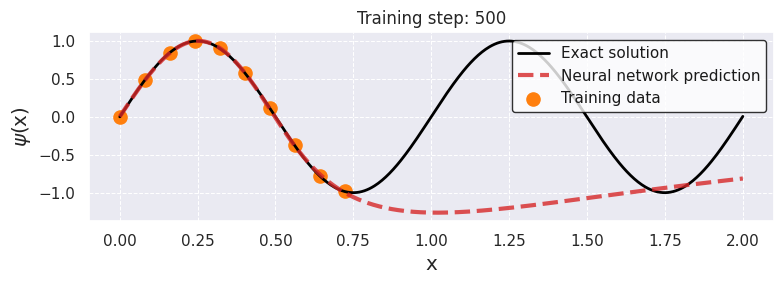

 98%|█████████▊| 978/1000 [00:02<00:00, 541.03it/s]

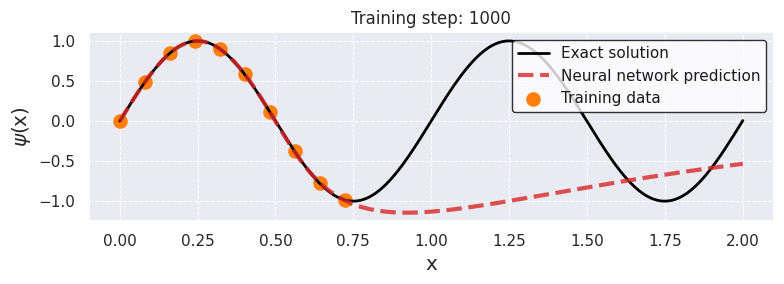

100%|██████████| 1000/1000 [00:03<00:00, 315.75it/s]


In [109]:
torch.manual_seed(123) # Set a fixed seed for reproducibility of results.

model = FCN_TANH(1, 1, 32, 3) # Initialize the model with TANH activation layers.

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Set up the optimizer with the Adam algorithm and a learning rate of 1e-3.

losses = []

for i in tqdm(range(1000)):                  # Training loop for 1000 iterations.
    optimizer.zero_grad()                    # Clear gradients for the next training iteration.
    yh = model(x_data)                       # Forward pass: compute the model output.
    loss = torch.mean((yh - y_data) ** 2)    # Compute the loss using mean squared error.
    loss.backward()                          # Backpropagation: compute gradient of the loss with respect to model parameters.
    optimizer.step()                         # Update model parameters.
    losses.append(loss.detach())             # Store the loss value.

    # Plotting the training progress at specific iterations.
    if (i + 1) == 1 or (i + 1) % 500 == 0:
        yh = model(x).detach()
        plot_result(x, y, x_data, y_data, yh)
        plt.show()
    else:
        plt.close("all")


  0%|          | 0/1000 [00:00<?, ?it/s]

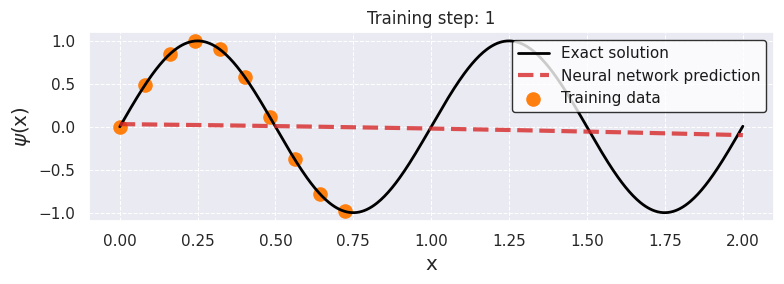

 47%|████▋     | 472/1000 [00:01<00:01, 490.87it/s]

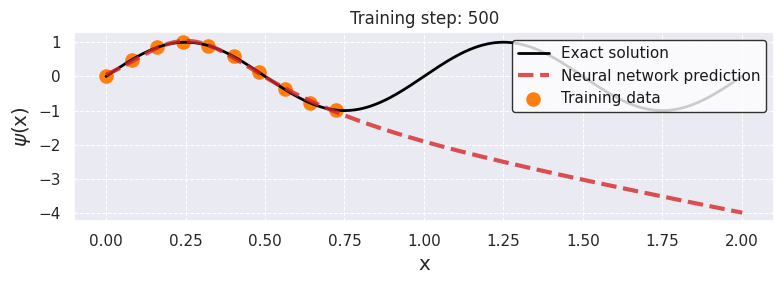

 98%|█████████▊| 985/1000 [00:03<00:00, 468.60it/s]

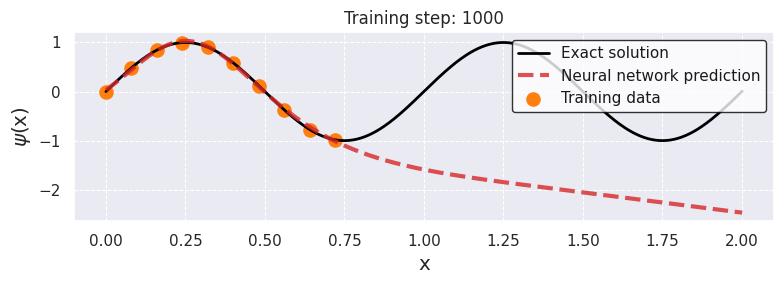

100%|██████████| 1000/1000 [00:03<00:00, 284.66it/s]


In [110]:
# train standard neural network to fit training data - TANH activation for example but it does not converge with any
torch.manual_seed(123)
model = FCN_GELU(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for i in tqdm(range(1000)):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()


    if (i+1) == 1 or (i+1) % 500 == 0:  # This will be true at step 1, 500, 1000, etc.
        yh = model(x).detach()
        plot_result(x, y, x_data, y_data, yh)
        plt.show()  # Show the plot for step 1, 500, 1000, etc.
    else:
        plt.close("all")  # Close any figures that are not needed.


  0%|          | 0/1000 [00:00<?, ?it/s]

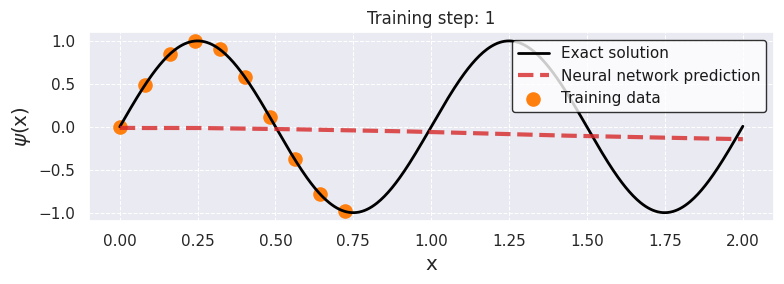

 47%|████▋     | 469/1000 [00:01<00:01, 526.47it/s]

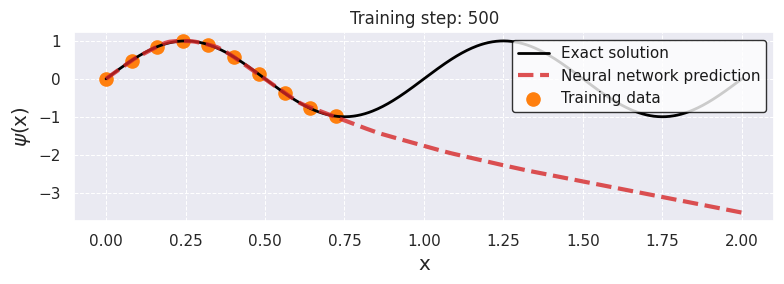

 95%|█████████▍| 949/1000 [00:02<00:00, 532.30it/s]

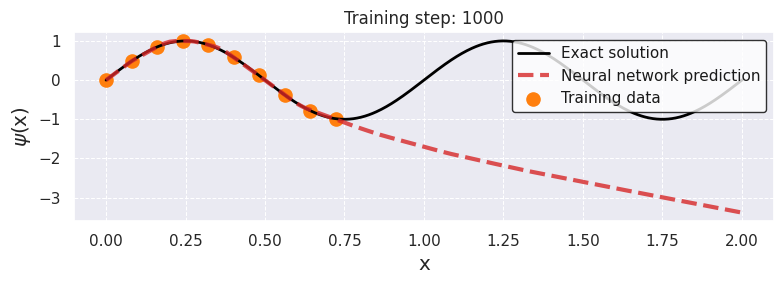

100%|██████████| 1000/1000 [00:03<00:00, 316.61it/s]


In [111]:
# train standard neural network to fit training data - TANH activation for example but it does not converge with any
torch.manual_seed(123)
model = FCN_RELU(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for i in tqdm(range(1000)):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()


    # plot the result as training progresses
    if (i+1) == 1 or (i+1) % 500 == 0:  # This will be true at step 1, 500, 1000, etc.
        yh = model(x).detach()
        plot_result(x, y, x_data, y_data, yh)
        plt.show()  # Show the plot for step 1, 500, 1000, etc.
    else:
        plt.close("all")  # Close any figures that are not needed.

- No activation function has been able to achieve convergence.
- The available data points are insufficient for the neural network to accurately predict its behavior.

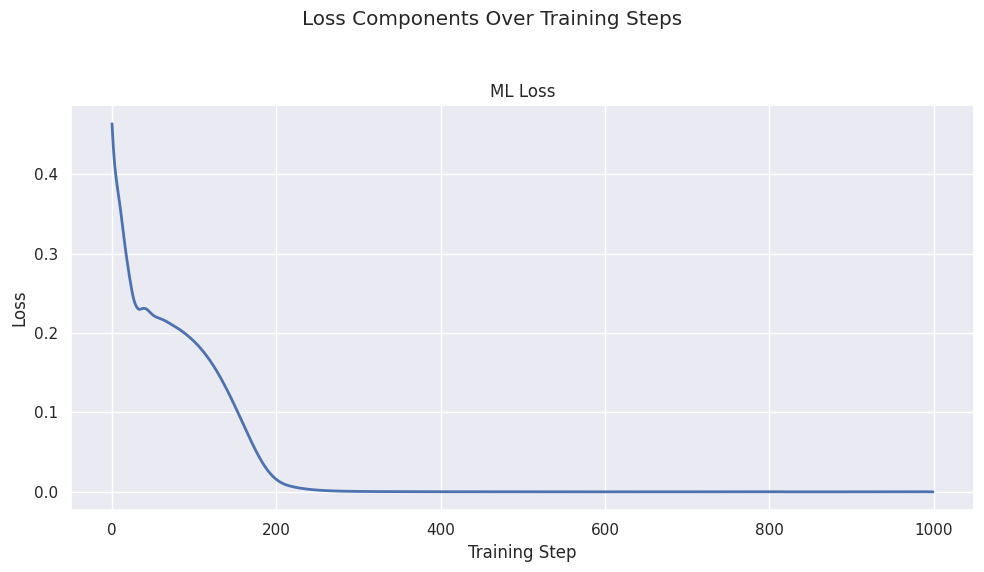

In [134]:
plot_losses(losses)

This indicates that the computational model is performing optimally given its current capabilities but is unable to achieve further improvements due to the need for more data.

$\textbf{Incorporating Physics into the Loss Function}$

We introduce the concept of Physics-Informed Neural Networks (PINNs) by defining a composite loss function that integrates physical laws with data-driven learning. The total loss function, $\text{Loss}_{\text{total}}$, is a weighted sum of four distinct components:

\begin{equation*}
\text{Loss}_{\text{total}} = \lambda_1 \left( \frac{1}{N} \sum_{i=1}^{N} (\hat{y}_i - y_{\text{data}, i})^2 \right) + \lambda_2 \left( \frac{1}{M} \sum_{j=1}^{M} \left( \frac{d^2 \hat{y}_j}{dx^2} + k^2 \hat{y}_j \right)^2 \right) + \lambda_3 (\hat{y}_{\text{boundary}, 1} - 0)^2 + \lambda_4 (\hat{y}_{\text{boundary}, 2} - 0)^2
\end{equation*}

where:

- $\lambda_1, \lambda_2, \lambda_3, \lambda_4$ are the weights assigned to each component of the loss function, indicating their relative importance.
- The first term is the mean squared error between the predicted values $\hat{y}_i$ and the observed data $y_{\text{data}, i}$ over $N$ data points. This term ensures the model's predictions are consistent with the observed data.
- The second term introduces the physics-informed component by penalizing deviations from a specified differential equation. Here, $\frac{d^2 \hat{y}_j}{dx^2} + k^2 \hat{y}_j$ represents the differential equation governing the system's behavior, with $k$ being a constant, and the sum is taken over $M$ collocation points.
- The third and fourth terms impose boundary conditions at two specific points, ensuring the model's predictions adhere to known physical constraints at the boundaries. The expressions $(\hat{y}_{\text{boundary}, 1} - 0)^2$ and $(\hat{y}_{\text{boundary}, 2} - 0)^2$ force the model predictions at the boundary points to be zero.

This loss function is then simplified to a more generic form:

\begin{equation*}
    Loss = \lambda_1 Loss_1 + \lambda_2 Loss_2 + \lambda_3 Loss_3 + \lambda_4 Loss_4
\end{equation*}

Each $Loss_i$ term corresponds to one of the four components mentioned, representing a modular way to describe the total loss. By adjusting the $\lambda$ weights, one can control the influence of each loss component, allowing for flexible tuning to achieve desired model performance that honors both the data and the underlying physical principles.







In [135]:
# sample locations over the problem domain
x_physics = torch.linspace(0,2,30).view(-1,1).requires_grad_(True)

# define boundary points, for the boundary loss
t_boundary1 = torch.tensor(0.).view(-1,1).requires_grad_(True)
t_boundary2 = torch.tensor(2.).view(-1,1).requires_grad_(True)


#set your constantes
hbar = 1
m = 1

#Define your differential equations terms
E = (n * np.pi * hbar) **2 / (2*m*a**2)
k_squared= (2*m*E) / (hbar**2)

########################

#Define the hyperparameters lambda:
lambda1 = 1
lambda2 = 1e-2
lambda3 = 1
lambda4 = 1e-1

 10%|▉         | 984/10000 [00:05<00:46, 195.00it/s]

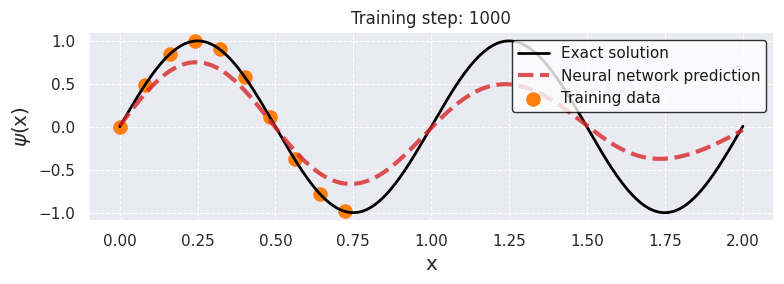

 20%|█▉        | 1995/10000 [00:11<00:40, 198.30it/s]

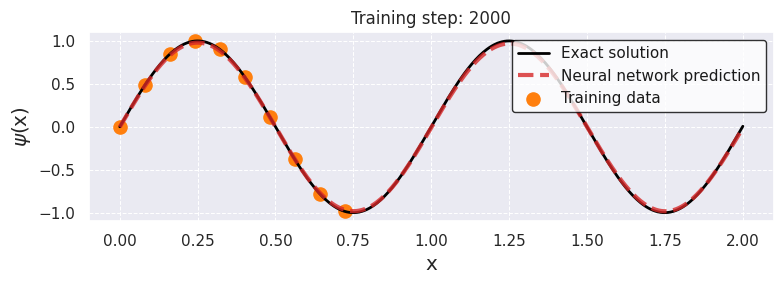

 30%|██▉       | 2980/10000 [00:17<00:35, 199.09it/s]

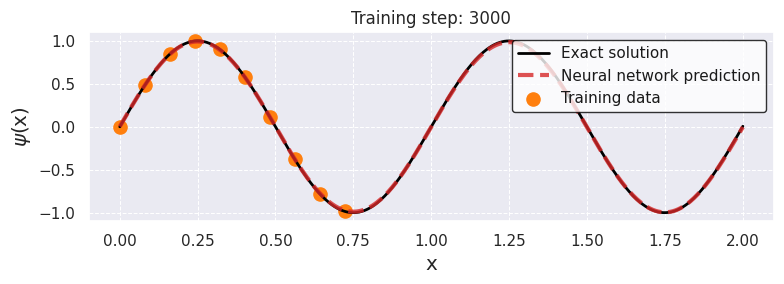

 40%|███▉      | 3992/10000 [00:23<00:30, 194.31it/s]

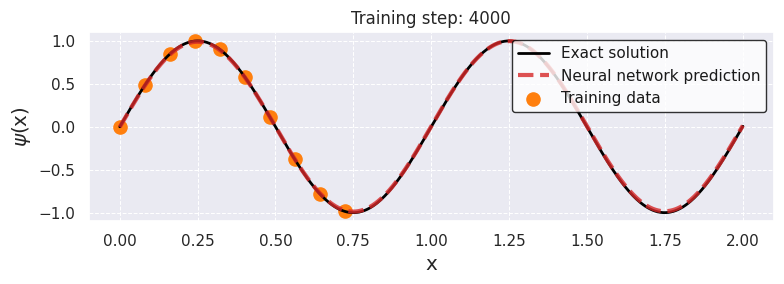

 50%|████▉     | 4982/10000 [00:29<00:25, 195.52it/s]

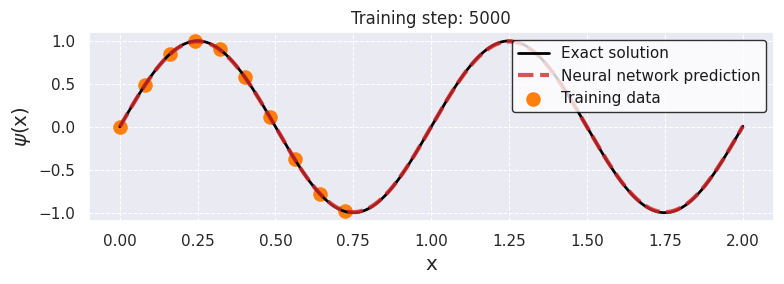

 57%|█████▋    | 5664/10000 [00:33<00:31, 138.10it/s]

In [ ]:
#Get the Neural Network going:

torch.manual_seed(123)
#define a neural network to train:
model = FCN_TANH(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

#to plot the loss function
losses1 = []
losses2 = []
losses3 = []
losses4 = []
lossestot = []

for i in tqdm(range(10000)):
    optimizer.zero_grad()

    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error

    # compute the "physics loss"

    # Equation:
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + k_squared*yhp # computes the residual of the 1D time independent schrodinger differential equation
    loss2 = torch.mean(physics**2)

    #Boundary Condition:
    y_boundary1 = model(t_boundary1)
    loss3 = (torch.squeeze(y_boundary1) - 0)**2
    y_boundary2 = model(t_boundary2)
    loss4 = (torch.squeeze(y_boundary2) - 0)**2

    # backpropagate joint loss
    loss = lambda1*loss1 + lambda2*loss2 + lambda3*loss3 + lambda4 * loss4# add two loss terms together
    loss.backward()
    optimizer.step()

    losses1.append(loss1.detach())
    losses2.append(loss2.detach())
    losses3.append(loss3.detach())
    losses4.append(loss4.detach())
    lossestot.append(loss.detach())


    # plot the result as training progresses
    if (i+1) % 1000 == 0:

        yh = model(x).detach()
        xp = x_physics.detach()

        plot_result(x,y,x_data,y_data,yh)

        if (i+1) % 2500 == 0: plt.show()
        else: plt.close("all")



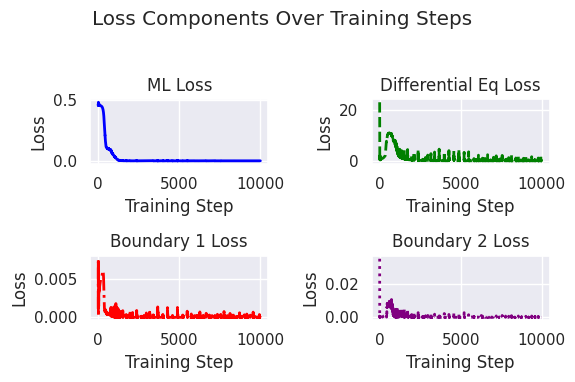

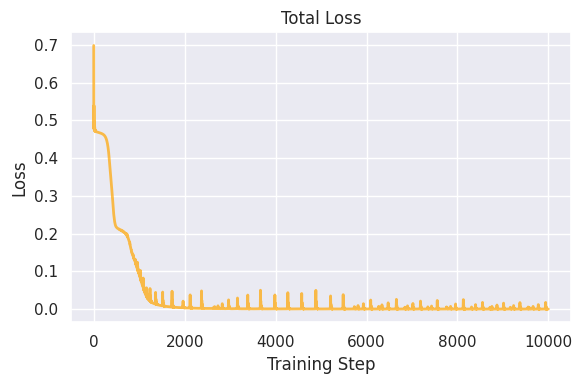

In [130]:
plot_losses_2x2(losses1,losses2,losses3, losses4, lossestot)

 10%|▉         | 997/10000 [00:09<01:08, 131.40it/s]

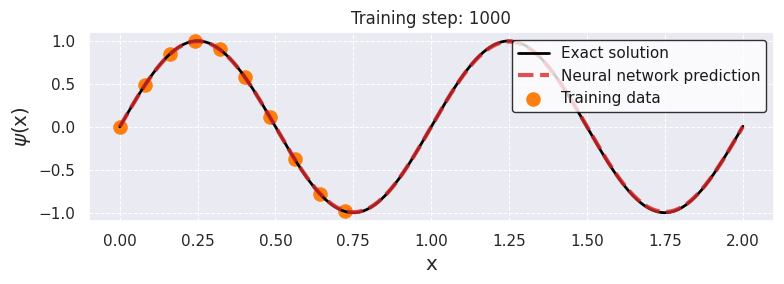

 20%|█▉        | 1999/10000 [00:23<01:00, 132.28it/s]

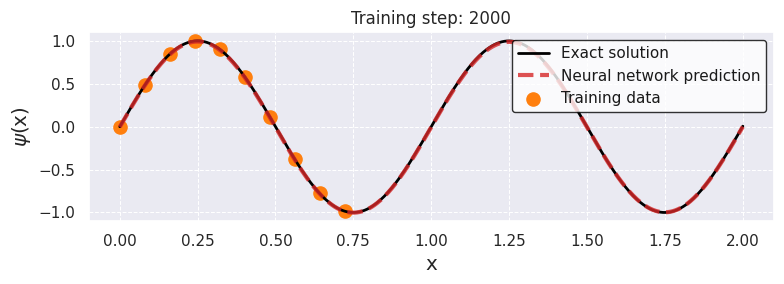

 30%|██▉       | 2993/10000 [00:32<01:16, 92.17it/s]

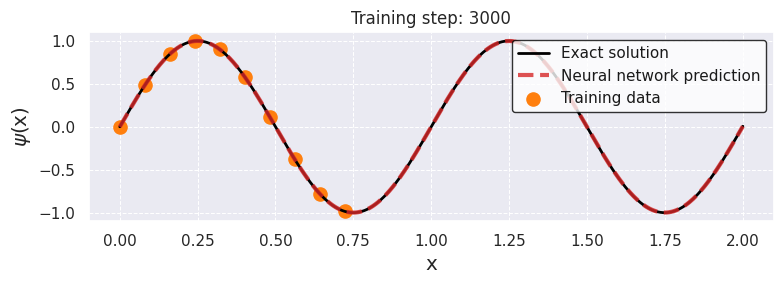

 40%|███▉      | 3995/10000 [00:40<00:46, 129.24it/s]

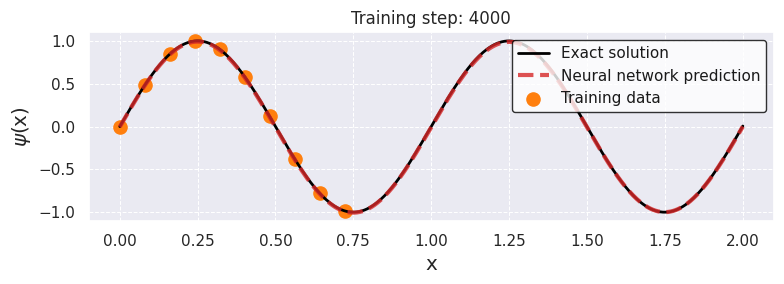

 50%|████▉     | 4990/10000 [00:50<00:39, 128.07it/s]

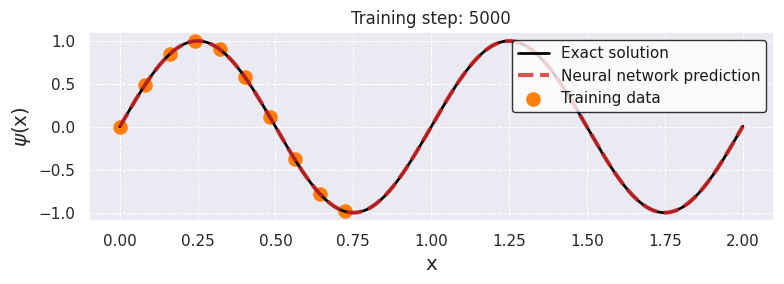

 60%|█████▉    | 5997/10000 [00:59<00:35, 111.29it/s]

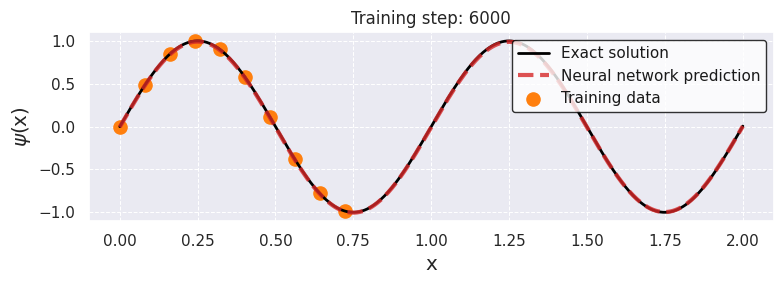

 70%|██████▉   | 6997/10000 [01:07<00:22, 131.85it/s]

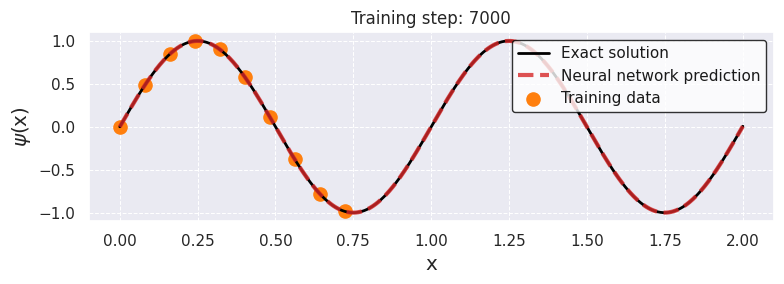

 80%|███████▉  | 7987/10000 [01:16<00:15, 129.94it/s]

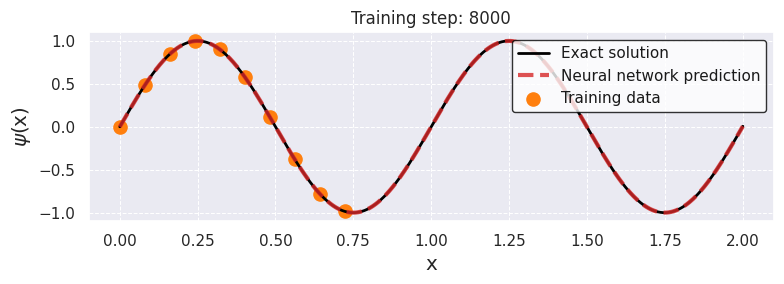

 90%|████████▉ | 8995/10000 [01:26<00:07, 131.52it/s]

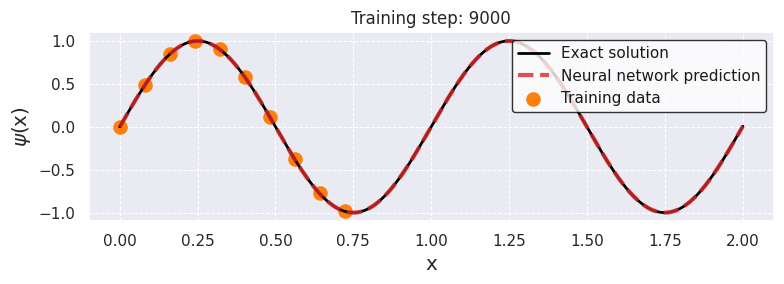

100%|█████████▉| 9988/10000 [01:34<00:00, 133.66it/s]

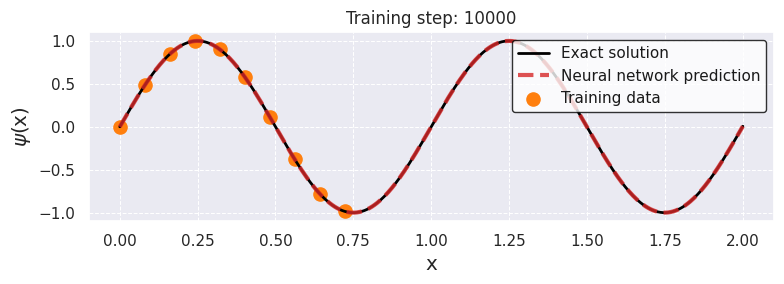

100%|██████████| 10000/10000 [01:34<00:00, 105.69it/s]


In [131]:
#Same but with GELU

#Get the Neural Network going:

torch.manual_seed(123)
#define a neural network to train:
model = FCN_GELU(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

#to plot the loss function
losses1 = []
losses2 = []
losses3 = []
losses4 = []
lossestot = []

for i in tqdm(range(10000)):
    optimizer.zero_grad()

    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error

    # compute the "physics loss"

    # Equation:
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + k_squared*yhp # computes the residual of the 1D time independent schrodinger differential equation
    loss2 = torch.mean(physics**2)

    #Boundary Condition:
    y_boundary1 = model(t_boundary1)
    loss3 = (torch.squeeze(y_boundary1) - 0)**2
    y_boundary2 = model(t_boundary2)
    loss4 = (torch.squeeze(y_boundary2) - 0)**2

    # backpropagate joint loss
    loss = lambda1*loss1 + lambda2*loss2 + lambda3*loss3 + lambda4 * loss4
    loss.backward()
    optimizer.step()

    losses1.append(loss1.detach())
    losses2.append(loss2.detach())
    losses3.append(loss3.detach())
    losses4.append(loss4.detach())
    lossestot.append(loss.detach())


    # plot the result as training progresses
    if (i+1) % 1000 == 0:

        yh = model(x).detach()
        xp = x_physics.detach()

        plot_result(x,y,x_data,y_data,yh)

        if (i+1) % 2500 == 0: plt.show()
        else: plt.close("all")



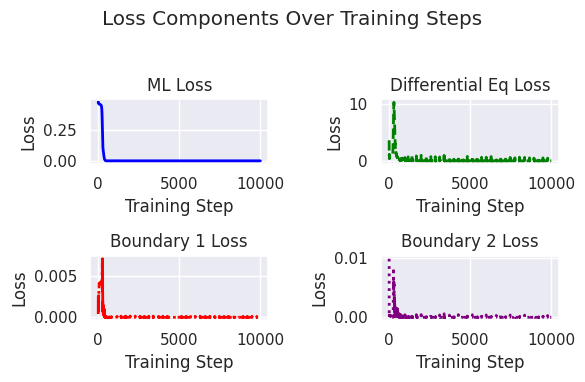

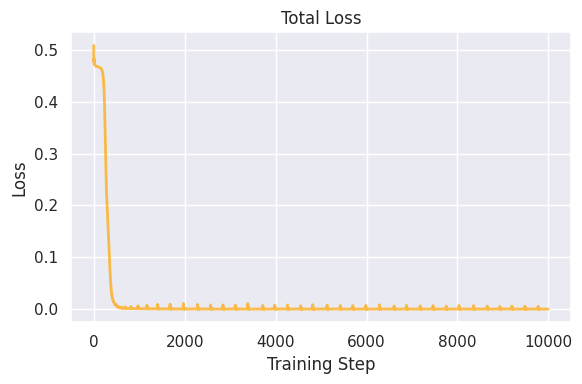

In [132]:
plot_losses_2x2(losses1,losses2,losses3, losses4, lossestot)

 10%|▉         | 994/10000 [00:04<00:39, 225.92it/s]

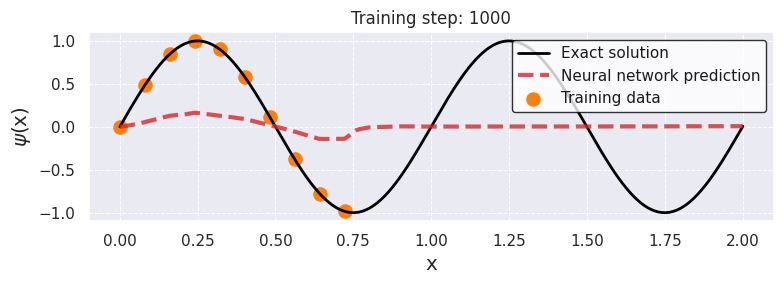

 20%|█▉        | 1991/10000 [00:09<00:37, 216.26it/s]

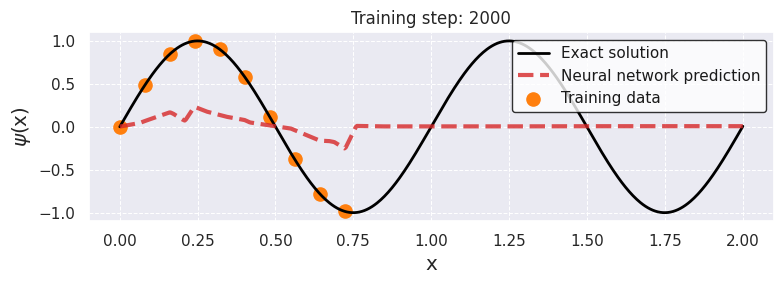

 30%|██▉       | 2986/10000 [00:18<00:32, 212.83it/s]

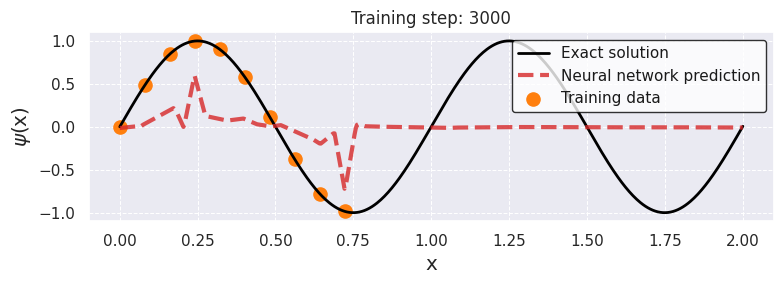

 40%|███▉      | 3993/10000 [00:23<00:28, 209.11it/s]

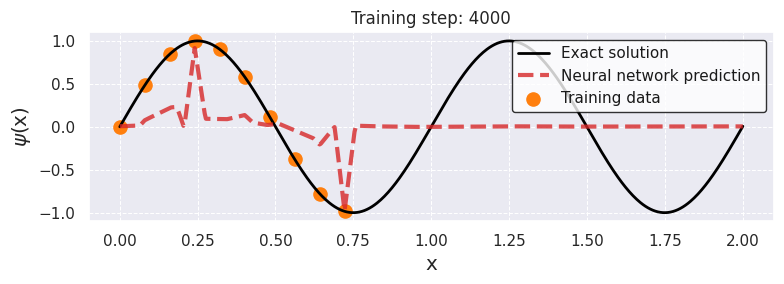

 50%|████▉     | 4996/10000 [00:29<00:23, 211.37it/s]

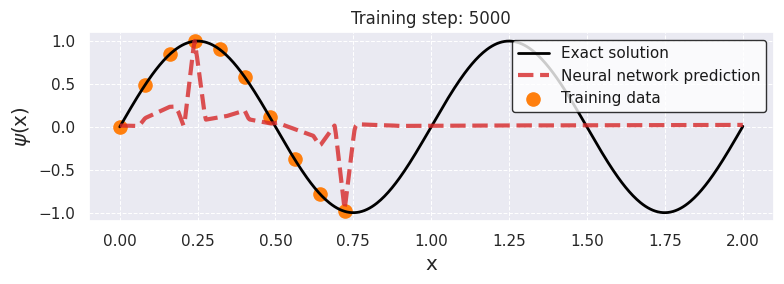

 60%|█████▉    | 5998/10000 [00:34<00:18, 216.73it/s]

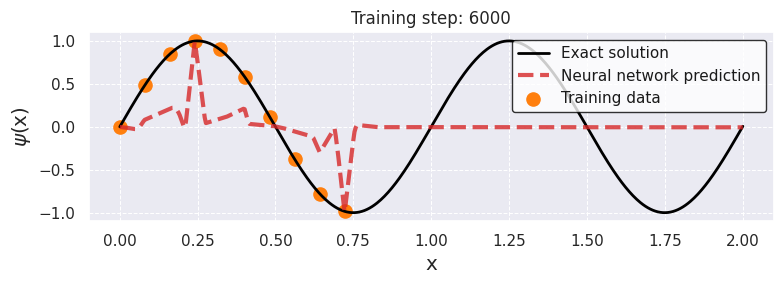

 70%|██████▉   | 6985/10000 [00:41<00:14, 206.48it/s]

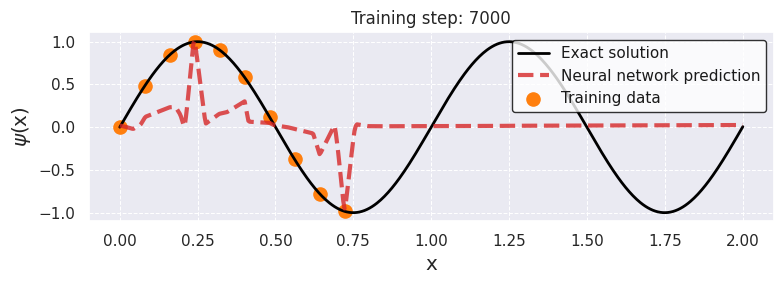

 80%|███████▉  | 7996/10000 [00:46<00:09, 207.84it/s]

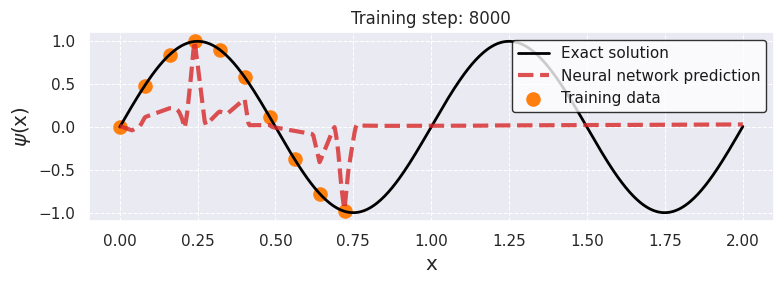

 90%|████████▉ | 8992/10000 [00:52<00:06, 146.73it/s]

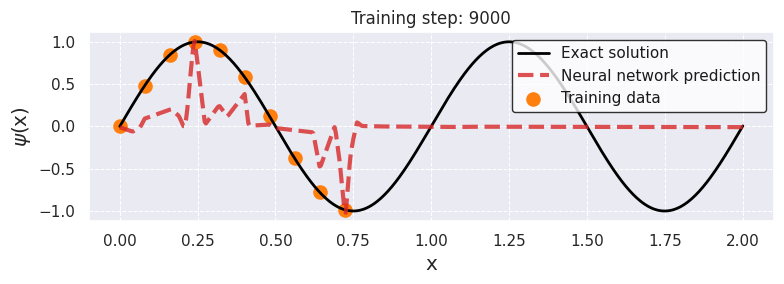

100%|█████████▉| 9977/10000 [00:57<00:00, 216.01it/s]

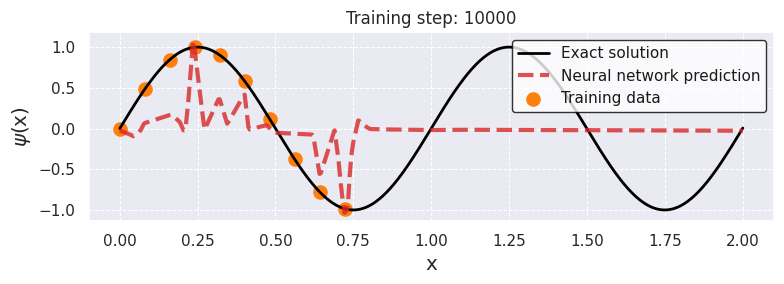

100%|██████████| 10000/10000 [00:58<00:00, 171.85it/s]


In [133]:
#Same but with RELU

#Get the Neural Network going:

torch.manual_seed(123)
#define a neural network to train:
model = FCN_RELU(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for i in tqdm(range(10000)):
    optimizer.zero_grad()

    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error

    # compute the "physics loss"

    # Equation:
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + k_squared*yhp # computes the residual of the  time independent schrodinger differential equation
    loss2 = torch.mean(physics**2)

    #Boundary Condition:
    y_boundary1 = model(t_boundary1)
    loss3 = (torch.squeeze(y_boundary1) - 0)**2
    y_boundary2 = model(t_boundary2)
    loss4 = (torch.squeeze(y_boundary2) - 0)**2

    # backpropagate joint loss
    loss = lambda1*loss1 + lambda2*loss2 + lambda3*loss3 + lambda4 * loss4# add two loss terms together
    loss.backward()
    optimizer.step()


    # plot the result as training progresses
    if (i+1) % 1000 == 0:

        yh = model(x).detach()
        xp = x_physics.detach()

        plot_result(x,y,x_data,y_data,yh)

        if (i+1) % 2500 == 0: plt.show()
        else: plt.close("all")



- The Tanh and GELU activations function correctly.
- The ReLU activation behaves oddly.